In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('..')
from utils.metrics import AndersonDarlingDistance, KendallDependenceMetric

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [6]:
'''
Load Dataset
'''
data = pd.read_csv('../data_train_log_return.csv', header=None).drop(columns=[0])
scaler = StandardScaler().fit(data.values)
X_train = torch.Tensor(scaler.transform(data.values)).to(device)

'''
Load Metrics
'''
ad = AndersonDarlingDistance()
kd = KendallDependenceMetric()

def compute_metrics(batch):
    size = batch.size(0)
    device_ = batch.device
    _,x = model.sample(size,device_)
    anderson = ad(batch.clone().detach(), x.clone().detach())
    kendall  = kd(batch.clone().detach(), x.clone().detach())
    return anderson, kendall

def visual_3D(data):
    x = data[:,0]
    y = data[:,1]
    z = data[:,2]
    color = data[:,3]  # 4th dimension
    
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(x, y, z, c=color, cmap='viridis')
    
    plt.colorbar(scatter)
    ax.set_xlabel('1st Dimension')
    ax.set_ylabel('2nd Dimension')
    ax.set_zlabel('3rd Dimension')
    plt.show()

## GAN

In [7]:
'''
Model
'''

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

# Parameters
latent_dim = 64  # latent dim
data_dim = 4    # data dimension
lr = 0.0001     # learn rate

# initialize
generator = Generator(latent_dim, data_dim).to(device)
discriminator = Discriminator(data_dim).to(device)

# BCE Loss and optimizer
loss_function = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = optim.Adam(generator.parameters(), lr=lr)

'''
Training
'''
epochs = 2000
batch_size = 512

for epoch in tqdm(range(epochs)):
    for i in range(0, len(X_train), batch_size):
        real_data = torch.Tensor(X_train[i:min(i+batch_size, len(X_train))])
        fake_data = generator(torch.randn(len(real_data), latent_dim).to(device))

        # Train Discriminator
        d_optimizer.zero_grad()
        real_loss = loss_function(discriminator(real_data), torch.ones(len(real_data), 1).to(device))
        fake_loss = loss_function(discriminator(fake_data.detach()), torch.zeros(len(real_data), 1).to(device))
        d_loss = real_loss + fake_loss
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        g_loss = loss_function(discriminator(fake_data), torch.ones(len(real_data), 1).to(device))
        g_loss.backward()
        g_optimizer.step()

    # Progress
    if (epoch+1) % 200 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Discriminator Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f} \n\
              Anderson Darling Distance: {float(ad.forward(real_data, fake_data)):.4f} Kendall Dependence: {float(kd.forward(real_data, fake_data)):.4f}")


 11%|███                         | 223/2000 [00:01<00:16, 105.67it/s]

Epoch 200/2000, Discriminator Loss: 0.9007, Generator Loss: 0.9846 
              Anderson Darling Distance: 44.7248 Kendall Dependence: 0.0904


 21%|█████▊                      | 418/2000 [00:03<00:13, 114.37it/s]

Epoch 400/2000, Discriminator Loss: 1.2851, Generator Loss: 0.9406 
              Anderson Darling Distance: 34.0828 Kendall Dependence: 0.0572


 31%|████████▌                   | 613/2000 [00:05<00:12, 110.74it/s]

Epoch 600/2000, Discriminator Loss: 1.3585, Generator Loss: 0.9326 
              Anderson Darling Distance: 16.5951 Kendall Dependence: 0.0150


 41%|███████████▍                | 818/2000 [00:06<00:10, 110.02it/s]

Epoch 800/2000, Discriminator Loss: 1.4144, Generator Loss: 0.6135 
              Anderson Darling Distance: 8.2057 Kendall Dependence: 0.0098


 51%|█████████████▋             | 1013/2000 [00:08<00:08, 111.66it/s]

Epoch 1000/2000, Discriminator Loss: 1.3694, Generator Loss: 0.7103 
              Anderson Darling Distance: 13.0191 Kendall Dependence: 0.0112


 61%|████████████████▍          | 1221/2000 [00:10<00:06, 111.74it/s]

Epoch 1200/2000, Discriminator Loss: 1.3823, Generator Loss: 0.7299 
              Anderson Darling Distance: 4.0297 Kendall Dependence: 0.0146


 71%|███████████████████        | 1416/2000 [00:12<00:05, 111.77it/s]

Epoch 1400/2000, Discriminator Loss: 1.3633, Generator Loss: 0.6969 
              Anderson Darling Distance: 3.7431 Kendall Dependence: 0.0199


 81%|█████████████████████▉     | 1624/2000 [00:13<00:03, 111.96it/s]

Epoch 1600/2000, Discriminator Loss: 1.3418, Generator Loss: 0.7231 
              Anderson Darling Distance: 2.8861 Kendall Dependence: 0.0186


 91%|████████████████████████▌  | 1819/2000 [00:15<00:01, 111.77it/s]

Epoch 1800/2000, Discriminator Loss: 1.3939, Generator Loss: 0.7183 
              Anderson Darling Distance: 13.5033 Kendall Dependence: 0.0357


100%|███████████████████████████| 2000/2000 [00:16<00:00, 117.77it/s]

Epoch 2000/2000, Discriminator Loss: 1.3527, Generator Loss: 0.7044 
              Anderson Darling Distance: 3.3330 Kendall Dependence: 0.0107


Anderson Darling Distance: 7.2699         
Kendall Dependence: 0.0091


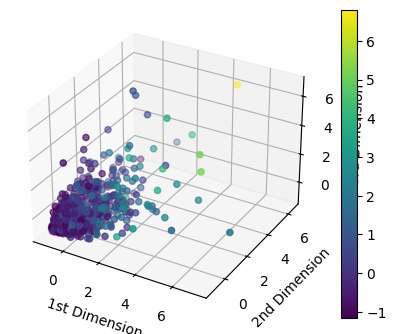

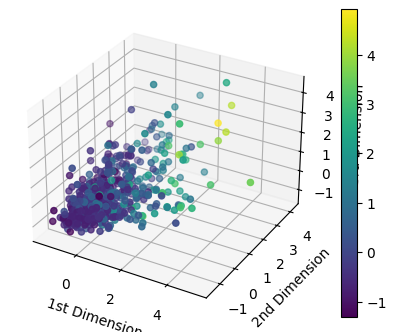

In [8]:
'''
Evaluation
'''
# Sampling
sample = generator(torch.randn(len(X_train), latent_dim).to(device))

print(f'Anderson Darling Distance: {float(ad.forward(X_train, sample)):.4f} \
        \nKendall Dependence: {float(kd.forward(X_train, sample)):.4f}')

visual_3D(X_train.cpu().detach().numpy())
visual_3D(sample.cpu().detach().numpy())

## Warsserstein GAN

In [26]:
'''
Model
'''
class W_Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(W_Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

class W_Critic(nn.Module):
    def __init__(self, input_dim):
        super(W_Critic, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        return self.fc(x)

# Parameters
latent_dim = 64  # latent dim
data_dim = 4    # data dimension
lr = 0.0001     # learn rate

# initialize
generator = W_Generator(latent_dim, data_dim).to(device)
critic = W_Critic(data_dim).to(device)

# BCE Loss and optimizer
critic_optimizer = optim.Adam(critic.parameters(), lr=lr)
g_optimizer = optim.Adam(generator.parameters(), lr=lr)

'''
Training
'''
epochs = 2000
batch_size = 512
clip_value = 5

for epoch in tqdm(range(epochs)):
    for i in range(0, len(X_train), batch_size):

        real_data = torch.Tensor(X_train[i:min(i+batch_size, len(X_train))]).to(device)
        critic_optimizer.zero_grad()
        critic_real = critic(real_data)
        
        fake_data = generator(torch.randn(len(real_data), latent_dim).to(device))
        critic_fake = critic(fake_data)
        
        critic_loss = -torch.mean(critic_real) + torch.mean(critic_fake)
        critic_loss.backward()
        critic_optimizer.step()

        # Weight Clipping
        for p in critic.parameters():
            p.data.clamp_(-clip_value, clip_value)

        # Train Generator
        g_optimizer.zero_grad()
        gen_data = generator(torch.randn(len(real_data), latent_dim).to(device))
        g_loss = -torch.mean(critic(gen_data))
        g_loss.backward()
        g_optimizer.step()

    # Progress
    if (epoch+1) % 200 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}, Critic Loss: {critic_loss.item():.4f}, Generator Loss: {g_loss.item():.4f} \n\
              Anderson Darling Distance: {float(ad.forward(real_data, fake_data)):.4f} Kendall Dependence: {float(kd.forward(real_data, fake_data)):.4f}")


  1%|▎                            | 25/2000 [00:00<00:15, 129.28it/s]

Epoch 1/2000, Critic Loss: -0.0037, Generator Loss: -0.1638 
              Anderson Darling Distance: 89.8193 Kendall Dependence: 0.1194


 11%|███                         | 217/2000 [00:01<00:12, 145.77it/s]

Epoch 200/2000, Critic Loss: 2.2091, Generator Loss: -3.3441 
              Anderson Darling Distance: 375.5485 Kendall Dependence: 0.1782


 21%|█████▉                      | 425/2000 [00:02<00:10, 145.82it/s]

Epoch 400/2000, Critic Loss: 0.9575, Generator Loss: -0.0424 
              Anderson Darling Distance: 350.5043 Kendall Dependence: 0.0919


 31%|████████▋                   | 617/2000 [00:04<00:09, 145.74it/s]

Epoch 600/2000, Critic Loss: -0.8968, Generator Loss: -0.6270 
              Anderson Darling Distance: 95.4160 Kendall Dependence: 0.0751


 41%|███████████▌                | 825/2000 [00:05<00:08, 145.79it/s]

Epoch 800/2000, Critic Loss: -7.1192, Generator Loss: 8.1895 
              Anderson Darling Distance: 1045.5303 Kendall Dependence: 0.2413


 51%|█████████████▋             | 1017/2000 [00:06<00:06, 145.93it/s]

Epoch 1000/2000, Critic Loss: 1.5514, Generator Loss: 2.2121 
              Anderson Darling Distance: 113.4045 Kendall Dependence: 0.1232


 61%|████████████████▌          | 1225/2000 [00:08<00:05, 145.92it/s]

Epoch 1200/2000, Critic Loss: 0.2507, Generator Loss: 1.9879 
              Anderson Darling Distance: 85.8408 Kendall Dependence: 0.1066


 71%|███████████████████▏       | 1417/2000 [00:09<00:03, 146.09it/s]

Epoch 1400/2000, Critic Loss: -0.2183, Generator Loss: 1.1475 
              Anderson Darling Distance: 204.0672 Kendall Dependence: 0.0785


 81%|█████████████████████▉     | 1625/2000 [00:10<00:02, 145.98it/s]

Epoch 1600/2000, Critic Loss: 1.3083, Generator Loss: -1.7318 
              Anderson Darling Distance: 135.3221 Kendall Dependence: 0.1412


 91%|████████████████████████▌  | 1817/2000 [00:11<00:01, 145.58it/s]

Epoch 1800/2000, Critic Loss: 0.5535, Generator Loss: 6.0959 
              Anderson Darling Distance: 387.0606 Kendall Dependence: 0.0915


100%|███████████████████████████| 2000/2000 [00:13<00:00, 153.17it/s]

Epoch 2000/2000, Critic Loss: -0.3724, Generator Loss: 3.3894 
              Anderson Darling Distance: 128.2222 Kendall Dependence: 0.1679


Anderson Darling Distance: 425.9967         
Kendall Dependence: 0.1600


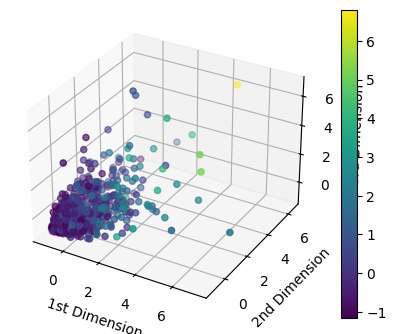

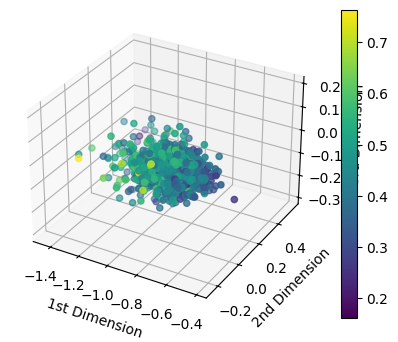

In [27]:
'''
Evaluation
'''
# from torchinfo import summary
# print(summary(generator, input_size=(1,4), device=device))
# print(summary(critic, input_size=(1,4)), device=device)


# Sampling
sample = generator(torch.randn(len(X_train), latent_dim).to(device))

print(f'Anderson Darling Distance: {float(ad.forward(X_train, sample)):.4f} \
        \nKendall Dependence: {float(kd.forward(X_train, sample)):.4f}')

sample = sample.cpu().detach().numpy()

visual_3D(X_train.cpu().detach().numpy())
visual_3D(sample)